In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
#from qiskit.test.mock import FakeAlmaden
#backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
theta = np.pi/3

In [7]:
schedules = []

In [8]:
schedule = (cmd_def.get('u2', qubits=[0], P0=0, P1=1) | cmd_def.get('u2', qubits=[1], P0=-np.pi/2, P1=np.pi/2))

schedule |= cmd_def.get('cx', qubits=[0, 1]) << schedule.duration
schedule |= cmd_def.get('u1', qubits=[1], P0=theta) << schedule.duration
schedule |= cmd_def.get('cx', qubits=[0, 1]) << schedule.duration

schedule |= (cmd_def.get('u2', qubits=[0], P0=np.pi, P1=-np.pi) | cmd_def.get('u2', qubits=[1], P0=-np.pi/2, P1=np.pi/2)) << schedule.duration

schedule |= measure << schedule.duration

schedules.append(schedule)

In [9]:
N = 2
circ = q.QuantumCircuit(N)
circ.ry(np.pi / 2, 0)
circ.rx(np.pi / 2, 1)
circ.zz_interaction(theta, 0, 1)
circ.ry(-np.pi / 2, 0)
circ.rx(np.pi / 2, 1)

decomposed_circuit = circ.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


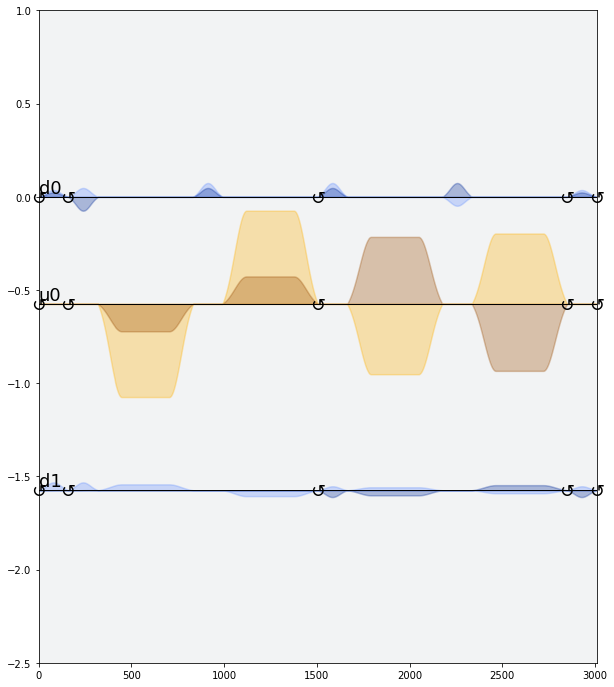

In [10]:
schedules[0].draw(table=False, channels=[config.drive(0), config.drive(1), config.control(0)])

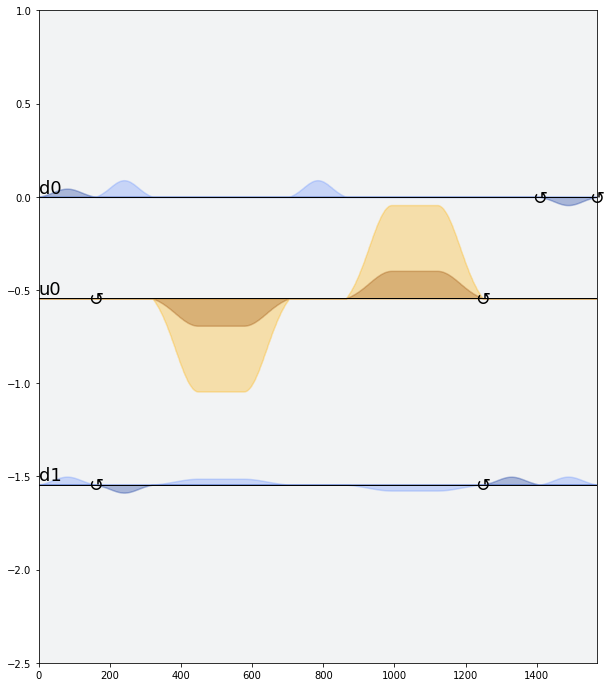

In [11]:
schedules[1].draw(table=False, channels=[config.drive(0), config.drive(1), config.control(0)])

In [12]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5ddc8a1f3f37b50011607f6f


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [13]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

# Run a mitigation cal job

In [14]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [15]:
job_mit = q.execute(meas_schedules, backend, shots=shots)
print('job_mit is %s' % job_mit.job_id())

job_mit is 5ddc8a358935270011b62b48


In [16]:
job_mit.status()

<JobStatus.VALIDATING: 'job is being validated'>

-----
## Analysis

In [17]:
from qiskit.result import marginal_counts

In [18]:
result = job.result()

In [19]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[9.67375e-01, 6.85000e-02, 7.97500e-02, 6.25000e-03],
       [1.92500e-02, 9.16000e-01, 2.50000e-03, 7.68750e-02],
       [1.30000e-02, 2.12500e-03, 9.00250e-01, 7.93750e-02],
       [3.75000e-04, 1.33750e-02, 1.75000e-02, 8.37500e-01]])

In [20]:
standard_counts = marginal_counts(result.get_counts(0), [0,1])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

before mitigation:
{'00': 709, '01': 2071, '10': 4997, '11': 223}



 after mitigation:
{'00': 117.81487160181767, '01': 2233.6942329945805, '10': 5533.5743455900865, '11': 114.91654981351503}


In [21]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

before mitigation:
{'00': 640, '01': 2091, '10': 5079, '11': 190}



 after mitigation:
{'00': 36.9576731253916, '01': 2260.4737310106057, '10': 5629.449868438841, '11': 73.11872742516108}


In [22]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [23]:
standard_counts

{'00': 117, '01': 2233, '10': 5533, '11': 114}

In [24]:
optimized_counts

{'00': 36, '01': 2260, '10': 5629, '11': 73}

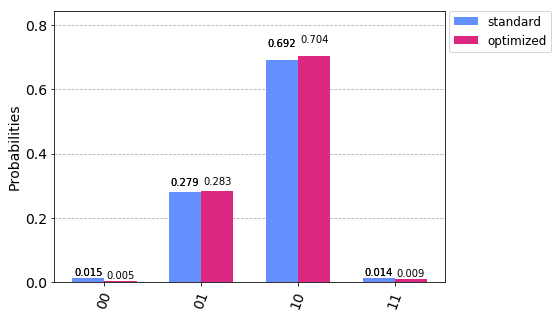

In [25]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [26]:
ideal_counts = {'01': 0.25, '10': 0.75}  # https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22Y%5E%C2%BD%22%2C%22X%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%22pi%2F3%22%7D%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22Y%5E-%C2%BD%22%2C%22X%5E%C2%BD%22%5D%5D%7D
# standard_counts =
# optimized_counts =

In [27]:
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

0.03284721057945984
0.017066307623352414


In [28]:
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))

0.5951823551982681
0.5794014522421609


In [29]:
from qiskit.quantum_info import hellinger_fidelity
print(hellinger_fidelity(ideal_counts, standard_counts))
print(hellinger_fidelity(ideal_counts, optimized_counts))

0.875771793985852
0.9123656660760371


In [46]:
jobs = backend.jobs(limit=None)
    
sum_shots = 0
sum_exps = 0
for j in jobs:
    qobj = j.qobj()
    shots = qobj.config.shots
    exps = len(qobj.experiments)
    
    sum_exps += exps
    sum_shots += exps*shots

print(sum_exps)
print(sum_shots)

4667
7602472
